# Телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, оператору нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Данные

- contract_new.csv
- personal_new.csv
- internet_new.csv
- phone_new.csv

## Исследование датафрейма

In [1]:
#импортируем библиотеки
import warnings

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

RANDOM_STATE = 161023

In [2]:
#открываем файл
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

In [3]:
#объединяем таблицы
data = contract.merge(personal, on='customerID', how='outer')
data = data.merge(internet, on='customerID', how='outer')
data = data.merge(phone, on='customerID', how='outer')

In [4]:
#смотрим общую информацию
display(data.head(20))
data.info()
data.describe()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


In [5]:
#посмотрим на пропуски
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

пропуски есть во всех столбцах из таблицы internet и phone

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [7]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


присутствие пропусков в таблицах internet и phone связаны с отсутсвием информации об подключении услуги, скорей всего они просто не подключены

In [8]:
#найдем дубликаты
data.duplicated().sum()

0

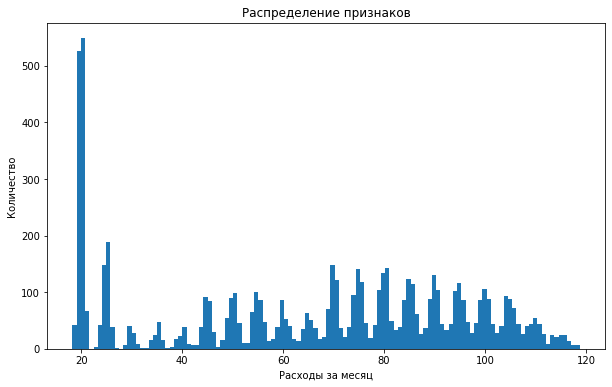

In [9]:
#построим график распределения признаков столбца MonthlyCharges
plt.figure(figsize=(10, 6))
plt.hist(data['MonthlyCharges'], bins=120) 
plt.xlabel('Расходы за месяц')
plt.ylabel('Количество')
plt.title('Распределение признаков')
plt.show()

на графике расходов за месяц видно большое количество расходов в районе 20, а остальные значения расположены в диапазоне от 30 до 120

**Вывод:**

- объединили таблицы
- есть пропуски в таблицах `internet` и `phone`, связаны с отсутсвием информации об оказании услуги, значит они не пользуются этими услугами
- отсутсвуют дубликаты
- не все столбцы имеют правильный тип данных
- бинарные признаки имеют значения Yes/No
- расходы за месяц в основном в районе 20, остальные значения в диапозоне от 30 до 120

# План работы

1. Подготовка данных:
- Загрузить данные
- Ознакомиться с данными
2. Исследовательский анализ данных:
- Изучение структуры данных, выявление пропусков и аномалий
- Анализ распределения признаков
3. Предобработка данных:
- Преобразовать бинарные признаки в числовые значения
- Обработать пропуски
3. Подготовка данных для обучения модели:
- Выделение целевой переменной и определение признаков
- Разделение данных на обучающую и тестовую выборки
4. Обучение и оценка модели:
- Выбор модели машинного обучения для прогнозирования оттока
- Обучение модели на обучающей выборке и оценка ее производительности на тестовой выборке, включая оценку метрик

## Предобработка данных

In [10]:
#приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [11]:
#найдем неявные пропуски в столбце totalcharges
pattern = r'[^0-9\.]'
invalid_values = data[data['totalcharges'].str.contains(pattern, na=False)]['totalcharges'].values
print(invalid_values)

[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']


In [12]:
#выведем данные с пропусками
data[data['totalcharges'] == ' ']

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


в столбце totalcharges присутствуют неявные пропуски, дата заключения договора, это дата выгрузки данных 1 февраля 2020 года, скорей всего клиенты только пришли и не прошло много времени. Данных с пропусками немного, значит их можно удалить

In [13]:
#приведем столбцы к нужному типу данных
data = data[data['totalcharges'] != ' ']
data['totalcharges'] = data['totalcharges'].astype('float')

In [14]:
#добавим новый столбец с целевым признаком
data['customer_left'] = data['enddate'].apply(lambda x: 0 if x == 'No' else 1)

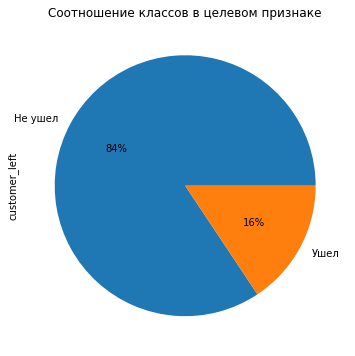

In [15]:
#построим круговую диаграмму распределения целевого признака
balance = data['customer_left'].value_counts(normalize=True)

balance.plot(kind='pie', autopct="%0.0f%%", figsize=(6, 6), labels = ['Не ушел', 'Ушел'])
plt.title("Соотношение классов в целевом признаке")
plt.show()

видно, что тех кто не ушел больше

In [16]:
#заменим значение в столбце enddate с No на дату выгрузки датафрейма
data['enddate'] = data['enddate'].replace('No', '2020-02-01')

In [17]:
#преобразуем столбцы к правильному типу даты
data['begindate'] = pd.to_datetime(data['begindate'])
data['enddate'] = pd.to_datetime(data['enddate'])

In [18]:
#добавим признак длительности контракта в днях
data['contract_duration'] = (data['enddate'] - data['begindate']).dt.days

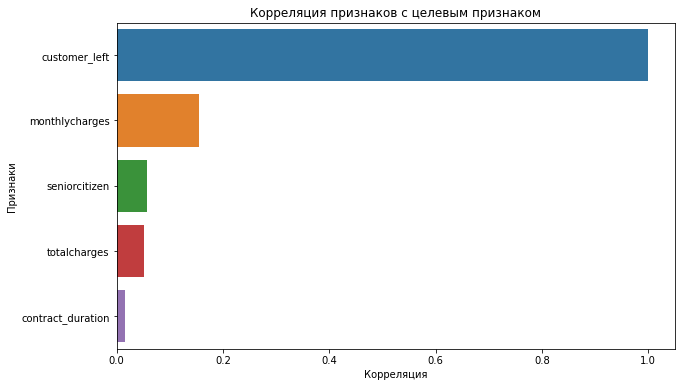

In [19]:
#вычислим корреляцию между признаками и целевым признаком
correlations = data.corrwith(data['customer_left'])
correlations = correlations.abs().sort_values(ascending=False)

#отобразим важность признаков
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel('Корреляция')
plt.ylabel('Признаки')
plt.title('Корреляция признаков с целевым признаком')
plt.show()

monthlycharges имеет наибольшую корреляцию с customer_left. Это может указывать на то, что клиенты с более высокими ежемесячными платежами более склонны к уходу.

seniorcitizen и totalcharges также имеют корреляцию с customer_left, но их влияние слабее по сравнению с monthlycharges.

contract_duration имеет самую низкую корреляцию с customer_left, что может означать, что длительность контракта не сильно влияет на решение клиентов об уходе.

In [20]:
#удалим ненужные столбцы
data = data.drop(['customerid', 'begindate', 'enddate'], axis=1)

In [21]:
#заполним пропуски заглушкой
data = data.fillna('unknown')

In [22]:
#сбросим индексы
data.reset_index(drop=True, inplace=True)
print(data.index.is_monotonic_increasing)

True


## Подготовка данных для обучения

In [23]:
#разобьем данные на выборки
data_train, data_test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)
display(data_train.shape)
display(data_test.shape)

(5274, 19)

(1758, 19)

In [24]:
#закодируем данные
categorical_columns = ['type', 'paperlessbilling', 'paymentmethod', 'gender', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(data_train[categorical_columns]))
data_train_ohe = data_train.join(encoder_df)
data_train_ohe.drop(categorical_columns, axis=1, inplace=True)
data_train_ohe = data_train_ohe.fillna(-1)

encoder_df = pd.DataFrame(encoder.transform(data_test[categorical_columns]))
data_test_ohe = data_test.join(encoder_df)
data_test_ohe.drop(categorical_columns, axis=1, inplace=True)
data_test_ohe = data_test_ohe.fillna(-1)

features_train_ohe = data_train_ohe.drop(['customer_left'], axis=1)
target_train_ohe = data_train_ohe['customer_left']
features_test_ohe = data_test_ohe.drop(['customer_left'], axis=1)
target_test_ohe = data_test_ohe['customer_left']

features_train = data_train.drop(['customer_left'], axis=1)
target_train = data_train['customer_left']
features_test = data_test.drop(['customer_left'], axis=1)
target_test = data_test['customer_left']

In [25]:
display(features_train_ohe.shape)
display(features_test_ohe.shape)
display(features_train.shape)
display(features_test.shape)

(5274, 43)

(1758, 43)

(5274, 18)

(1758, 18)

In [26]:
#создаем список с числовыми столбцами
numeric = ['monthlycharges', 'totalcharges', 'contract_duration']

In [27]:
#нормируем числовые данные
scaler = StandardScaler()
features_train_ohe[numeric] = scaler.fit_transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

print(features_train_ohe.shape)
print(features_test_ohe.shape)

(5274, 43)
(1758, 43)


## Обучение моделей

найдем лучшие гиперпараметры для каждой модели с помощью GridSearchCV

### модель случайный лес

In [28]:
#%%time

#model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

#param_grid = {
    #'n_estimators': [200, 500, 1000],
    #'max_depth': [None, 10, 20, 30],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
#}
#grid_rf = GridSearchCV(estimator=model_rf, 
                       #param_grid=param_grid, 
                       #scoring='roc_auc', 
                       #cv=5, 
                       #n_jobs=1)
#grid_rf.fit(features_train_ohe, target_train_ohe)
#print('Лучшая оценка AUC-ROC на кросс-валидации: ', grid_rf.best_score_)
#print('Лучшие гиперпараметры модели: ', grid_rf.best_params_)
#print('Лучшая модель: ', grid_rf.best_estimator_)

In [29]:
%%time

model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
}
grid_rf = GridSearchCV(estimator=model_rf, 
                       param_grid=param_grid, 
                       scoring='roc_auc', 
                       cv=5, 
                       n_jobs=1)
grid_rf.fit(features_train_ohe, target_train_ohe)
print('Лучшая оценка AUC-ROC на кросс-валидации: ', grid_rf.best_score_)
print('Лучшие гиперпараметры модели: ', grid_rf.best_params_)
print('Лучшая модель: ', grid_rf.best_estimator_)

Лучшая оценка AUC-ROC на кросс-валидации:  0.7462487561453504
Лучшие гиперпараметры модели:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}
Лучшая модель:  RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000, random_state=161023)
CPU times: user 24.1 s, sys: 61.6 ms, total: 24.2 s
Wall time: 24.2 s


модель `RandomForestClassifier`:
- Лучшая оценка AUC-ROC на кросс-валидации:  0.74

- Лучшие гиперпараметры модели:  max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000

### модель CatBoost

In [30]:
categorical_features = ['type', 'paperlessbilling', 'paymentmethod', 'gender', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

In [31]:
#%%time

#model_cbc = CatBoostClassifier(random_seed=RANDOM_STATE, verbose=0)

#param_grid = {
    #'iterations': [200, 500, 1000],
    #'depth': [1, 6, 10],
    #'learning_rate': [0.01, 0.1, 0.5],
    #'l2_leaf_reg': [1, 4, 7],
#}
#grid_cbc = GridSearchCV(estimator=model_cbc, 
                        #param_grid=param_grid, 
                        #scoring='roc_auc', 
                        #cv=5,
                        #n_jobs=1)
#grid_cbc.fit(features_train, target_train, cat_features=categorical_features)
#print('Лучшая оценка AUC-ROC на кросс-валидации: ', grid_cbc.best_score_)
#print('Лучшие гиперпараметры модели: ', grid_cbc.best_params_)
#print('Лучшая модель: ', grid_cbc.best_estimator_)

In [32]:
%%time

model_cbc = CatBoostClassifier(random_seed=RANDOM_STATE, verbose=0)

param_grid = {
    'iterations': [1000],
    'depth': [6],
    'learning_rate': [0.1],
    'l2_leaf_reg': [1],
}
grid_cbc = GridSearchCV(estimator=model_cbc, 
                        param_grid=param_grid, 
                        scoring='roc_auc', 
                        cv=5,
                        n_jobs=1)
grid_cbc.fit(features_train, target_train, cat_features=categorical_features)
print('Лучшая оценка AUC-ROC на кросс-валидации: ', grid_cbc.best_score_)
print('Лучшие гиперпараметры модели: ', grid_cbc.best_params_)
print('Лучшая модель: ', grid_cbc.best_estimator_)

Лучшая оценка AUC-ROC на кросс-валидации:  0.8980514757670626
Лучшие гиперпараметры модели:  {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Лучшая модель:  <catboost.core.CatBoostClassifier object at 0x7f1881b6b8e0>
CPU times: user 1min 22s, sys: 1.39 s, total: 1min 23s
Wall time: 1min 31s


модель `CatBoostClassifier`:
- Лучшая оценка AUC-ROC на кросс-валидации:  0.89

- Лучшие гиперпараметры модели: depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1

### модель LightGBM

In [33]:
#%%time

#model_lgb = LGBMClassifier(random_state=RANDOM_STATE)
#param_grid = {
    #'n_estimators': [200, 500, 1000],
    #'max_depth': [1, 5, 10],
    #'learning_rate': [0.01, 0.1, 0.5],
    #'num_leaves': [31, 63, 127],
#}
#grid_lgb = GridSearchCV(estimator=model_lgb, 
                        #param_grid=param_grid, 
                        #scoring='roc_auc',
                        #cv=5,
                        #n_jobs=1)
#grid_lgb.fit(features_train_ohe, target_train_ohe)
#print('Лучшая оценка AUC-ROC на кросс-валидации: ', grid_lgb.best_score_)
#print('Лучшие гиперпараметры модели: ', grid_lgb.best_params_)
#print('Лучшая модель: ', grid_lgb.best_estimator_)

In [34]:
%%time

model_lgb = LGBMClassifier(random_state=RANDOM_STATE)
param_grid = {
    'n_estimators': [500],
    'max_depth': [5],
    'learning_rate': [0.1],
    'num_leaves': [63],
}
grid_lgb = GridSearchCV(estimator=model_lgb, 
                        param_grid=param_grid, 
                        scoring='roc_auc',
                        cv=5,
                        n_jobs=1)
grid_lgb.fit(features_train_ohe, target_train_ohe)
print('Лучшая оценка AUC-ROC на кросс-валидации: ', grid_lgb.best_score_)
print('Лучшие гиперпараметры модели: ', grid_lgb.best_params_)
print('Лучшая модель: ', grid_lgb.best_estimator_)

Лучшая оценка AUC-ROC на кросс-валидации:  0.8601716160069257
Лучшие гиперпараметры модели:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 63}
Лучшая модель:  LGBMClassifier(max_depth=5, n_estimators=500, num_leaves=63,
               random_state=161023)
CPU times: user 4min 6s, sys: 4.9 s, total: 4min 11s
Wall time: 4min 12s


модель `LGBMClassifier`:
- Лучшая оценка AUC-ROC на кросс-валидации:  0.86

- Лучшие гиперпараметры модели: learning_rate=0.1, max_depth=5, n_estimators=500, num_leaves=63

In [35]:
models = {'Модель':['RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier'], 
          'AUC-ROC': [0.74, 0.89, 0.86],
          'Время подбора гиперпараметров': ['21m 4s', '1h 28m 46s', '1h 37m 52s'],
          'Время обучения с лучшими гиперпараметрами': ['22.3 s', '1m 22s', '4min 5s']}

df = pd.DataFrame(models)
df

,Модель,AUC-ROC,Время подбора гиперпараметров,Время обучения с лучшими гиперпараметрами
0,RandomForestClassifier,0.74,21m 4s,22.3 s
1,CatBoostClassifier,0.89,1h 28m 46s,1m 22s
2,LGBMClassifier,0.86,1h 37m 52s,4min 5s


**Вывод:**

 Обучили три модели: 
- RandomForestClassifier AUC-ROC = 0.74
- CatBoostClassifier AUC-ROC = 0.89
- LGBMClassifier AUC-ROC = 0.85
 
 Лучшую метрику AUC-ROC на кросс-валидации показала модель `CatBoostClassifier` с результатом AUC-ROC = 0.89.
 
 С гиперпараметрами:
- depth=6
- iterations=1000
- l2_leaf_reg=1
- learning_rate=0.1

Эту модель будем использовать для проверки качества на тестовой выборке.

# Тестирование лучшей модели

In [36]:
#протестируем Catboos на тестовой выборке
best_model_cbc = grid_cbc.best_estimator_

predicted_proba = best_model_cbc.predict_proba(features_test)

probabilities = predicted_proba[:, 1]

roc_auc = roc_auc_score(target_test, probabilities)

print('AUC-ROC на тестовой выборке: ', roc_auc)

AUC-ROC на тестовой выборке:  0.9162229831367271


смогли получить нужную метрику AUC-ROC >= 0.85

AUC-ROC на тестовой выборке = 0.91

Text(0.5, 1.0, 'Важности признаков')

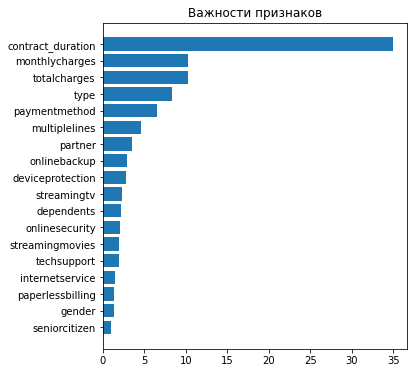

In [37]:
#построим график для понимания важности признаков
feature_importance = best_model_cbc.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_test.columns)[sorted_idx])
plt.title("Важности признаков")

больше всего важны длительность контракта, одинаково важны расходы за месяц и общие расходы абонента, меньше всего важны является ли абонент пенсионером и его пол

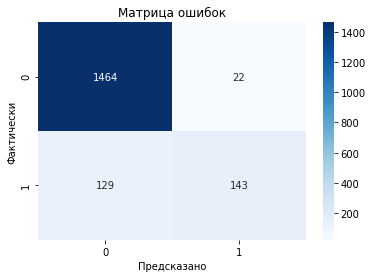

In [38]:
#выведем матрицу ошибок
predictions = best_model_cbc.predict(features_test)
confusion = confusion_matrix(target_test, predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Предсказано")
plt.ylabel("Фактически")
plt.title("Матрица ошибок")
plt.show()

модель правильно классифицировала большинство отрицательных объектов и довольно неплохо справилась с положительными объектами

## Отчет работы

### Какие пункты плана были выполнены, а какие - нет(поясните, почему)?

-   Подготовка данных
    - [x]  Загрузить данные
    - [x]  Ознакомиться с данными
-   Исследовательский анализ данных
    - [x]  Изучение структуры данных, выявление пропусков и аномалий
    - [x]  Анализ распределения признаков
-   Предобработка данных
    - [x]  Преобразовать бинарные признаки в числовые значения
    - [x]  Обработать пропуски
-   Подготовка данных для обучения модели
    - [x]  Выделение целевой переменной и определение признаков
    - [x]  Разделение данных на обучающую и тестовую выборки
-   Обучение и оценка модели
    - [x]  Выбор модели машинного обучения для прогнозирования оттока
    - [x]  Обучение модели на обучающей выборке и оценка ее производительности на тестовой выборке, включая оценку метрик

Все пункты плана выполнены.

### Какие трудности возникли и как вы с ними справились?

Возникли проблемы с низкой метрикой AUC-ROC модели RandomForest, потом я сделал нормированние числовых данных и метрика улучшилась. Еще я сделал кодирование данных до разделения на выборки, после замечания ментора сделал как надо.

### Какие ключевые шаги в решении задачи выделили?

- подготовка и предобработка данных
- анализ данных
- создание новых и удаление ненужных признаков
- подготовка данных для обучения
- поиск лучшей модели
- тестирование лучшей модели
- анализ лучшей модели

### Какая итоговая модель, какие у нее гиперпараметры и какое качество?

Лучшая модель это `CatBoostClassifier` с гиперпараметрами:
- depth=6
- iterations=1000
- l2_leaf_reg=1
- learning_rate=0.1
- random_state=161023

Итоговое качество:
- AUC-ROC = 0.91

### Список признаков, используемых для обучения лучшей модели, описание их предобработки.

- customer_left
- contract_duration
- monthlycharges
- totalcharges
- type
- paymentmethod
- multiplelines
- partner
- onlinebackup
- deviceprotection
- streamingtv
- dependents
- onlinesecurity
- streamingmovies
- techsupport
- internetservice
- paperlessbilling
- gender
- seniorcitizen

  Привел названия всех столбцов к нижнему регистру. 
  
  Удалил строки с пропусками в столбце totalcharges и привел к нужному типу данных. 
  
  Добавил целевой признак customer_left. 
  
  Добавил признак contract_duration. 
  
  Разделил данные на выборки размером 75% - тренировочная и 25% - тестовая.
  
  Для кодирования категориальных данных использовал OneHotEncoder, для масштабирование числовых данных использовал StandardScaler.